In [1]:
pip install pandas_datareader ecbdata


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install arch


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Test for serial dependence

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
import matplotlib.pyplot as plt

/Users/gloriapaggiaro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


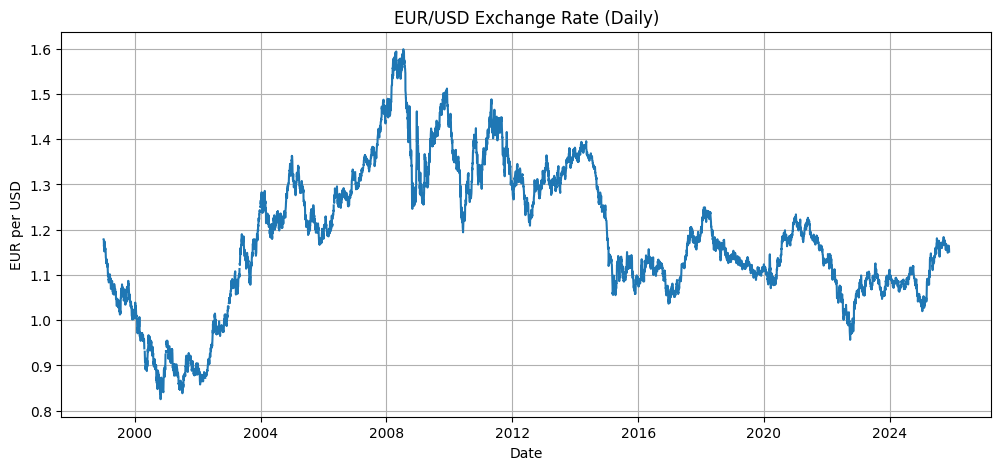

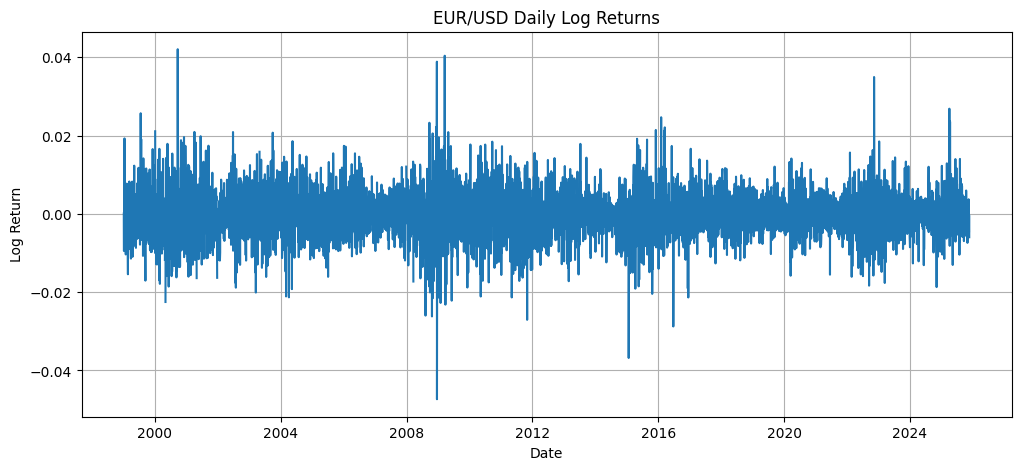

<Figure size 1200x400 with 0 Axes>

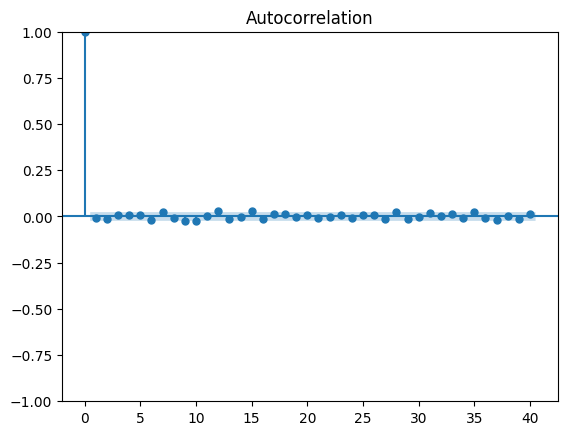

<Figure size 1200x400 with 0 Axes>

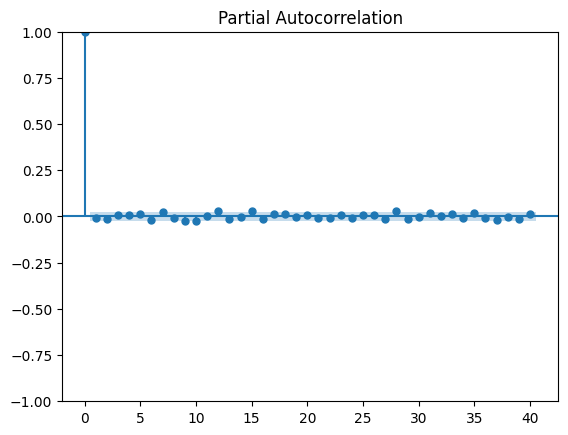

In [4]:
import matplotlib.pyplot as plt
from ecbdata import ecbdata

# 1. DOWNLOAD ECB DAILY EUR/USD EXCHANGE RATE
# 'EXR.D.USD.EUR.SP00.A' is the ECB series code for daily EUR/USD rate.
fx = ecbdata.get_series('EXR.D.USD.EUR.SP00.A')

# clean the dataset and keep only the date and observation value
# Converting to datetime and setting index allows for proper time series operations.
fx = fx[['TIME_PERIOD', 'OBS_VALUE']].copy()
fx['TIME_PERIOD'] = pd.to_datetime(fx['TIME_PERIOD'])
fx = fx.set_index('TIME_PERIOD')


# 2. COMPUTE LOG RETURNS (STATIONARY)
# Financial time series often have non-stationary levels, but usually log returns are approximately stationary.
fx['ret'] = np.log(fx['OBS_VALUE']).diff()


# 3. PLOT LEVEL SERIES
# Visualizing the original exchange rate series
# Level series often shows trends, cycles, or volatility clustering, but is non-stationary.
plt.figure(figsize=(12,5))
plt.plot(fx['OBS_VALUE'])
plt.title("EUR/USD Exchange Rate (Daily)")
plt.xlabel("Date")
plt.ylabel("EUR per USD")
plt.grid(True)
plt.show()

# 4. PLOT RETURNS
# Plotting log returns highlights volatility and potential clustering.
# Returns are stationary, making them suitable for time series modeling 
plt.figure(figsize=(12,5))
plt.plot(fx['ret'])
plt.title("EUR/USD Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()

# 5. ACF & PACF OF RETURNS
# Checking for serial correlation in returns using autocorrelation (ACF) and partial autocorrelation (PACF)
# If returns have no serial correlation, it confirms that the mean equation may be modeled as a constant plus the error term.

# Plot ACF: shows correlation of returns with lagged values
plt.figure(figsize=(12,4))
plot_acf(fx['ret'].dropna(), lags=40)
plt.show()

# Plot PACF: partial correlation controlling for intermediate lags
plt.figure(figsize=(12,4))
plot_pacf(fx['ret'].dropna(), lags=40, method="ywm")
plt.show()


In [6]:

# Compute ACF (Autocorrelation Function) with confidence intervals
# ACF measures linear correlation between the series and its lagged values.
# For FX returns, we expect low autocorrelation (series is close to white noise), but this confirms it quantitatively.
acf_vals, confint = acf(fx['ret'].dropna(), nlags=40, alpha=0.05, fft=False)
# nlags=40 → compute autocorrelation up to 40 daily lags.
# alpha=0.05 → 95% confidence intervals for each autocorrelation estimate.

# Calculate approximate t-values and p-values

import numpy as np
from scipy.stats import norm

n = len(fx['ret'].dropna())  # number of observations
# Standard error approximation for each lag: 1/sqrt(n)
# This comes from the theory that for a white noise series, 
# the standard deviation of the autocorrelation at lag k is approximately 1/sqrt(n)
se = 1 / np.sqrt(n)

# t-values: observed autocorrelation divided by its standard error
t_values = acf_vals / se

# Two-tailed p-values: probability of observing a value as extreme as t under H0: rho=0
p_values = 2 * (1 - norm.cdf(np.abs(t_values)))

# Build a table of results
# This table shows the lag, autocorrelation, t-stat, p-value, and confidence interval
acf_table = pd.DataFrame({
    "lag": range(len(acf_vals)),
    "ACF": acf_vals,
    "t_value": t_values,
    "p_value": p_values,
    "lower_CI": confint[:, 0],
    "upper_CI": confint[:, 1]
})

print(acf_table)


    lag       ACF    t_value   p_value  lower_CI  upper_CI
0     0  1.000000  82.728472  0.000000  1.000000  1.000000
1     1 -0.007318  -0.605407  0.544909 -0.031010  0.016374
2     2 -0.016167  -1.337473  0.181068 -0.039860  0.007526
3     3  0.006568   0.543391  0.586861 -0.017131  0.030267
4     4  0.008759   0.724613  0.468689 -0.014941  0.032459
5     5  0.010701   0.885286  0.376002 -0.013001  0.034403
6     6 -0.021753  -1.799558  0.071930 -0.045457  0.001952
7     7  0.021964   1.817041  0.069211 -0.001752  0.045680
8     8 -0.008289  -0.685771  0.492858 -0.032017  0.015438
9     9 -0.026297  -2.175486  0.029594 -0.050025 -0.002568
10   10 -0.024632  -2.037802  0.041570 -0.048378 -0.000887
11   11  0.000962   0.079604  0.936552 -0.022797  0.024722
12   12  0.030518   2.524712  0.011579  0.006759  0.054278
13   13 -0.015969  -1.321063  0.186480 -0.039750  0.007813
14   14 -0.005480  -0.453391  0.650267 -0.029268  0.018307
15   15  0.029707   2.457630  0.013986  0.005919  0.0534

## Test for mean significance

In [8]:
# Drop NaNs
returns = fx['ret'].dropna()

# Compute mean and t-test
mean_ret = returns.mean()
t_stat, p_value = stats.ttest_1samp(returns, 0)

print(f"Mean return: {mean_ret:.6f}")
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.6f}")

# Decide if mean removal is needed
if p_value < 0.05:
    print("Mean is statistically significant. Will remove it.")
    residuals = returns - mean_ret
else:
    print("Mean not significant. Use raw returns as residuals.")
    residuals = returns.copy()


Mean return: -0.000019
T-statistic: -0.270, p-value: 0.787134
Mean not significant. Use raw returns as residuals.


## Testing for conditional volatility

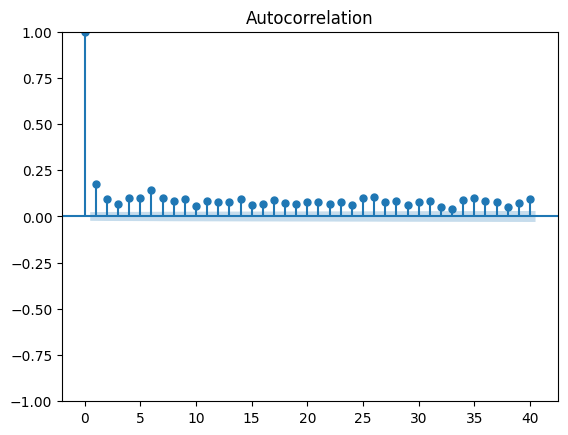

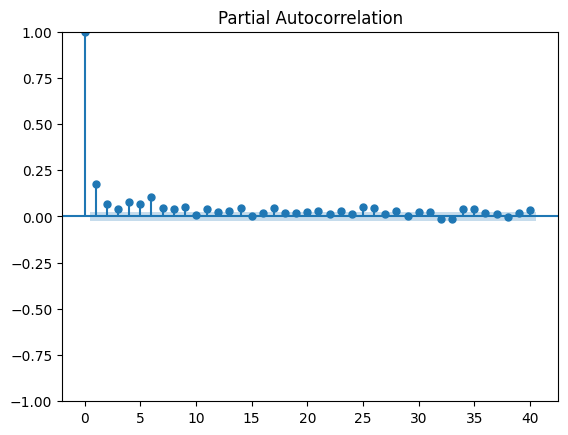

In [14]:
#plot ACF and PACF of squared returns to check for ARCH effects
plot_acf(returns**2, lags=40)
plot_pacf(returns**2, lags=40)
plt.show()


In [15]:
# Ljung-Box test on squared returns
lb_squared = acorr_ljungbox(returns**2, lags=[10, 20, 30], return_df=True)
print("Ljung-Box on squared returns:")
print(lb_squared)

Ljung-Box on squared returns:
        lb_stat      lb_pvalue
10   775.044403  4.772168e-160
20  1183.555872  2.457072e-238
30  1634.413747   0.000000e+00


In [16]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(returns, nlags=10)
labels = ["LM Stat", "LM p-value", "F Stat", "F p-value"]
print("\nEngle's ARCH LM test on returns:")
print(pd.Series(arch_test, index=labels))



Engle's ARCH LM test on returns:
LM Stat       4.331396e+02
LM p-value    8.225602e-87
F Stat        4.617054e+01
F p-value     9.050702e-90
dtype: float64


## Estimation of a GARCH (1,1) model

In [17]:
# Drop NaNs from return series
# Ensure that the series used for GARCH modeling is clean and has no missing values.

returns = fx['ret'].dropna()

# Fit GARCH(1,1) model

# Specify the model:
# - vol='Garch' : use the standard GARCH model for conditional variance
# - p=1, q=1   : GARCH(1,1), i.e., variance depends on 1 lag of squared residuals (ARCH term)
#               and 1 lag of past conditional variance (GARCH term)
# - mean='Zero': assumes the mean of the series is zero, since returns have no serial correlation
#   This is common in FX returns; if there were significant AR terms, we could specify mean='AR' or include a constant.
garch11 = arch_model(returns, vol='Garch', p=1, q=1, mean='Zero')

# Fit the model
# update_freq=5 controls how often progress is printed during optimization
res = garch11.fit(update_freq=5)

# Show the summary of estimated parameters
# Key outputs:
# - omega: constant term in variance equation
# - alpha[1]: ARCH term (impact of previous squared shocks)
# - beta[1]: GARCH term (impact of previous variance)
# - Persistence (alpha + beta) shows how long volatility shocks persist
print(res.summary())


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -25916.194557553346
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                25916.2
Distribution:                  Normal   AIC:                          -51826.4
Method:            Maximum Likelihood   BIC:                          -51805.9
                                        No. Observations:                 6844
Date:                Thu, Nov 20 2025   Df Residuals:                     6844
Time:                        22:17:04   Df Model:                            0
                              Volatility Model                              
     

/Users/gloriapaggiaro/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.426e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gloriapaggiaro/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


## Check Standardized residuals

In [18]:
# Compute standardized residuals
# Standardized residuals = raw residuals / conditional volatility
# - res.resid: residuals from the fitted GARCH model (difference between observed returns and model mean, here zero)
# - res.conditional_volatility: estimated conditional standard deviation at each time point
# 
# Why this is useful:
# 1. Standardized residuals should behave like i.i.d. white noise if the GARCH model fits well.
# 2. It allows us to check model adequacy: plot ACF/PACF of standardized residuals to see if any autocorrelation remains.
# 3. Can be used to test for remaining heteroskedasticity (e.g., using ARCH LM tests).
std_resid = res.resid / res.conditional_volatility
# Ljung-Box test on squared standardized residuals

# Test for remaining ARCH effects (conditional heteroskedasticity) 
# after fitting the GARCH model.
# - std_resid**2: squared standardized residuals, which should be approximately white noise if GARCH captured volatility clustering
# - lags=[10,20,30]: test at multiple horizons to check for autocorrelation in variance
# - return_df=True: return results as a pandas DataFrame

lb_test = acorr_ljungbox(std_resid**2, lags=[10,20,30], return_df=True)

# Print the test results
# Interpretation:
# H0: no autocorrelation in the squared residuals (no remaining ARCH effects)
# H1: autocorrelation present (remaining heteroskedasticity)
print("Ljung-Box on squared standardized residuals:")
print(lb_test)


Ljung-Box on squared standardized residuals:
      lb_stat  lb_pvalue
10  15.059141   0.129920
20  21.475192   0.369653
30  42.965667   0.059005


In [20]:
# Engle's ARCH LM test on standardized residuals
# Purpose:
# - Test for remaining conditional heteroskedasticity after fitting the GARCH model.
# - std_resid: standardized residuals from the GARCH model.
# - nlags=10: number of lags to include in the auxiliary regression for the test.

arch_test = het_arch(std_resid, nlags=10)

# Labels for the returned statistics
labels = ["LM Stat", "LM p-value", "F Stat", "F p-value"]

# Print results in a readable format
# Interpretation:
# - H0: no ARCH effects remaining (variance is homoskedastic)
# - H1: ARCH effects present (variance still depends on past squared residuals)
print("\nEngle's ARCH LM test on standardized residuals:")
print(pd.Series(arch_test, index=labels))



Engle's ARCH LM test on standardized residuals:
LM Stat       15.304595
LM p-value     0.121345
F Stat         1.531426
F p-value      0.121295
dtype: float64
